In [1]:
from keras.utils import np_utils
import itertools
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adagrad, adam
from keras.preprocessing import image
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization
import numpy as np
import pandas as pd
import os
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split


def extract_data(filepath):
    dataset = pd.read_csv( filepath, delimiter=',', dtype='a')
    labels = np.array(dataset['emotion'], np.float32)
    raw_data = np.array(dataset['pixels'])
    data = np.array([np.fromstring(i, np.uint8, sep=" ") for i in raw_data])
    data = (data - 128) / 255
    data = data.reshape(data.shape[0], 48, 48, 1)
    return data, labels


Using TensorFlow backend.


In [2]:
filepath = 'fer2013.csv'
label_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
data, labels = extract_data(filepath)
num_class = len(set(labels))

train_data, x_test, train_labels, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
print(len(x_train), len(x_valid), len(x_test))

y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_valid = (np.arange(num_class) == y_valid[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)


22967 5742 7178


In [3]:
def model_1():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(48, 48, 1), padding='same', name='conv1', kernel_regularizer=l2(1e-7)))
    model.add(BatchNormalization())
    # model.add(Conv2D(filters=32, kernel_size=5, activation='relu', padding='same', name='conv2'))
    model.add(MaxPool2D(pool_size=2, padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=64, kernel_size=5, activation='relu', padding='same', name='conv2', kernel_regularizer=l2(1e-7)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=128, kernel_size=5, activation='relu', padding='same', name='conv3', kernel_regularizer=l2(1e-7)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, padding='same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='Dense1', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu', name='Dense2', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(len(set(labels)), activation='softmax', name='Dense3'))
    opt = adam(lr=0.001, epsilon=1e-8, decay=1e-4)
    model.compile(optimizer=opt, metrics=['accuracy'], loss='categorical_crossentropy')
    model.summary()
    return model

In [4]:
model = model_1()
best_model= ModelCheckpoint('yt-2_Facial_Expression.hdf5', save_best_only=True, verbose=1)
stop = EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(x_train, y_train, batch_size=32, epochs=30, verbose=1, shuffle=True, callbacks=[best_model, stop], validation_data= (x_valid, y_valid))
# model.load_weights('yt-1_Facial_Expression.hdf5')
print('Evaluate Accuracy ', model.evaluate(x_test, y_test, batch_size=64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

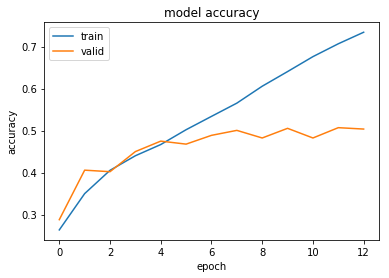

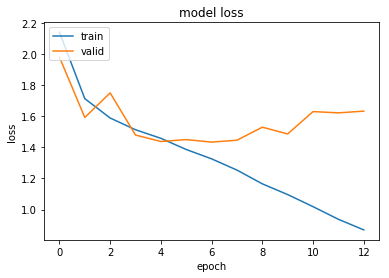

In [5]:
# summarize history for accuracy
plt.figure(1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Confusion Matrix 
Confusion matrix, without normalization
[[ 381    2  124  116  199   16  147]
 [  22   42   10   12   11    1    4]
 [ 104    4  369  127  268   47  124]
 [  76    4   81 1314  148   27  115]
 [ 116    7  128  181  513   18  247]
 [  38    3  125   83   38  431   77]
 [ 108    1   98  235  255   23  558]]


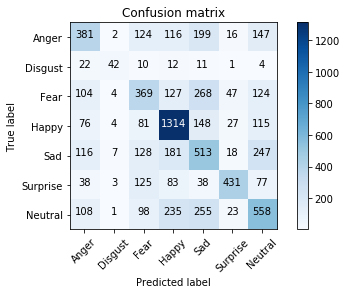

In [6]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print('Confusion Matrix ')


def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(7)
    plt.xticks(tick_marks, label_names, rotation=45)
    plt.yticks(tick_marks, label_names)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()